In [16]:
"""
Analysis pipeline on BERT models
"""

import numpy as np
from scipy.stats import sem
import matplotlib.pyplot as plt

from transformers import AutoModel, AutoModelForCausalLM, AutoModelForMaskedLM, AutoModelForSeq2SeqLM
from transformers import BertModel, AlbertModel, DistilBertModel, RobertaModel, BartModel, OpenAIGPTModel, GPT2Model

In [2]:
def decomposition_SN(A):
    
    S = np.linalg.norm(.5 * (A + A.T), 'fro') / np.linalg.norm(A, 'fro')
    N = np.linalg.norm(.5 * (A - A.T), 'fro') / np.linalg.norm(A, 'fro')

    return S, N

def decomposition_blocks(d,l,h,dh,A):
    
    S = np.zeros((l,h))
    N = np.zeros((l,h))

    for i, layer in enumerate(range(l)):
        for j, head in enumerate(range(0,d,dh)):
            S[i,j], N[i,j] = decomposition_SN(A[layer][head:head+dh,head:head+dh])
    return  S, N

In [3]:
def get_matricesBERT(model):

    layers = len(model.encoder.layer)    
    M = []
    for l in range(layers):
        Wq = model.encoder.layer[l].attention.self.query.weight.detach().numpy()
        Wk = model.encoder.layer[l].attention.self.key.weight.detach().numpy()
        M.append(Wq@(Wk.T))        

    return M

def get_matricesALBERT(model):

    layers = len(model.encoder.albert_layer_groups)    
    M = []
    for l in range(layers):
        Wq = model.encoder.albert_layer_groups[l].albert_layers[0].attention.query.weight.detach().numpy()
        Wk = model.encoder.albert_layer_groups[l].albert_layers[0].attention.key.weight.detach().numpy()
        M.append(Wq@(Wk.T))        

    return M

def get_matricesDistillBERT(model):

    layers = len(model.transformer.layer)
    M = []
    for l in range(layers):
        Wq = model.transformer.layer[l].attention.q_lin.weight.detach().numpy()
        Wk = model.transformer.layer[l].attention.k_lin.weight.detach().numpy()
        M.append(Wq@(Wk.T))        

    return M

def get_matricesBART(model):

    layers = len(model.encoder.layers)  
    M = []
    for l in range(layers):
        Wq = model.encoder.layers[l].self_attn.q_proj.weight.detach().numpy()
        Wk = model.encoder.layers[l].self_attn.k_proj.weight.detach().numpy()
        M.append(Wq@(Wk.T))        

    return M

def get_matricesGPT(d,model):

    layers = len(model.h)  
    M = []
    for l in range(layers):
        Wq = model.h[l].attn.c_attn.weight[:,:d].detach().numpy()
        Wk = model.h[l].attn.c_attn.weight[:,d:2*d].detach().numpy()
        M.append(Wq@(Wk.T))        

    return M

def get_matricesDistillGPT(d,model):

    layers = len(model.transformer.h)  
    M = []
    for l in range(layers):
        Wq = model.transformer.h[l].attn.c_attn.weight[:,:d].detach().numpy()
        Wk = model.transformer.h[l].attn.c_attn.weight[:,d:2*d].detach().numpy()
        M.append(Wq@(Wk.T))        

    return M

def get_matricesDistillROBERTA(model):

    layers = len(model.roberta.encoder.layer)    
    M = []
    for l in range(layers):
        Wq = model.roberta.encoder.layer[l].attention.self.query.weight.detach().numpy()
        Wk = model.roberta.encoder.layer[l].attention.self.key.weight.detach().numpy()
        M.append(Wq@(Wk.T))        

    return M

def get_matricesT5(model):

    layers = len(model.encoder.block)
    M = []
    for l in range(layers):
        Wq = model.encoder.block[l].layer[0].SelfAttention.q.weight.detach().numpy()
        Wk = model.encoder.block[l].layer[0].SelfAttention.k.weight.detach().numpy()
        M.append(Wq@(Wk.T))        

    return M

def get_matricesOPT(model):

    layers = len(model.model.decoder.layers)
    M = []
    for l in range(layers):
        Wq = model.model.decoder.layers[l].self_attn.q_proj.weight.detach().numpy()
        Wk = model.model.decoder.layers[l].self_attn.k_proj.weight.detach().numpy()
        M.append(Wq@(Wk.T))        

    return M


In [4]:
'define dictionary'
models = {}

In [5]:
""" 
BERT models 
 - MODEL: Bidirectional, Encoder-only Transformer
 - DATASETS: BookCorpus & English Wikipedia
 - OBJECTIVES: Masked Language Modeling (MLM), Next Sentence Prediction (NSP)
 - METRICS: perplexity, cross-entropy

 MLM: randomly masked some words in the sentence, predict masked words with cross-entropy 
 over the vocaboulary 
 NSP: 

 
The idea is that these models have a better understanding of context, where each word is represented as a 
linear combination of all the other words in the sentence.
"""
dh = 64

'BERT tiny (l = 2, d = 128, h = 2 ; 4.40M parameters)'
l = 2
d = 128
h = d // dh
model = AutoModel.from_pretrained("google/bert_uncased_L-2_H-128_A-2")
M = get_matricesBERT(model)
SBert_tiny, NBert_tiny = decomposition_blocks(d,l,h,dh,M)

'BERT mini (l = 4, d = 256, h = 4 ; 11.3M parameters)'
l = 4
d = 256
h = d // dh
model = AutoModel.from_pretrained("google/bert_uncased_L-4_H-256_A-4")
M = get_matricesBERT(model)
SBert_mini, NBert_mini = decomposition_blocks(d,l,h,dh,M)

'BERT small (l = 4, d = 512, h = 8 ; 29.1M parameters)'
l = 4
d = 512
h = d // dh
model = AutoModel.from_pretrained("google/bert_uncased_L-4_H-512_A-8")
M = get_matricesBERT(model)
SBert_small, NBert_small = decomposition_blocks(d,l,h,dh,M)

'BERT medium (l = 8, d = 512, h = 8 ; 41.7M parameters)'
l = 8
d = 512
h = d // dh
model = AutoModel.from_pretrained("google/bert_uncased_L-8_H-512_A-8")
M = get_matricesBERT(model)
SBert_medium, NBert_medium = decomposition_blocks(d,l,h,dh,M)

'BERT base (l = 12, d = 768, h = 12 ; 110M parameters)'
l = 12
d = 768
h = d // dh
model = BertModel.from_pretrained("bert-base-uncased")
M = get_matricesBERT(model)
SBert_base, NBert_base = decomposition_blocks(d,l,h,dh,M)

'BERT large (l = 24, d = 1024, h = 16 ; 340M parameters)'
l = 24
d = 1024
h = d // dh
model = BertModel.from_pretrained("bert-large-uncased")
M = get_matricesBERT(model)
SBert_large, NBert_large = decomposition_blocks(d,l,h,dh,M)

'BERT large (masking) (l = 24, d = 1024, h = 16 ; 340M parameters)'
l = 24
d = 1024
h = d // dh
model = BertModel.from_pretrained("bert-large-uncased-whole-word-masking")
M = get_matricesBERT(model)
SBert_largeMasking, NBert_largeMasking = decomposition_blocks(d,l,h,dh,M)

In [6]:
""" 
Generative Pre-trained Transformers (GPT) models 
 - MODEL: Unidirectional (causal), Decoder-only Transformer
 - DATASETS: BookCorpus & English Wikipedia
 - OBJECTIVES: Masked Language Modeling (MLM), Next Sentence Prediction (NSP)

The idea is that these models have a better understanding of context, where each word is represented as a 
linear combination of all the other words in the sentence.
"""
dh = 64

'GPT 1 (l = 12, d = 768, h = 12 ; 110M parameters)'
l = 12
d = 768
h = d // dh
model = OpenAIGPTModel.from_pretrained("openai-gpt")
M = get_matricesGPT(d,model)
SGPT, NGPT = decomposition_blocks(d,l,h,dh,M)

'GPT2 (l = 12, d = 768, h = 12 ; 117M parameters)'
l = 12
d = 768
h = d // dh
model = GPT2Model.from_pretrained('gpt2')
M = get_matricesGPT(d,model)
SGPT2, NGPT2 = decomposition_blocks(d,l,h,dh,M)

'GPT2 medium (l = 24, d = 1024, h = 16 ; 345M parameters)'
l = 24
d = 1024
h = d // dh
model = GPT2Model.from_pretrained('gpt2-medium')
M = get_matricesGPT(d,model)
SGPT2_medium, NGPT2_medium = decomposition_blocks(d,l,h,dh,M)

'GPT2 large (l = 36, d = 1280, h = 20 ; 774M parameters)'
l = 36
d = 1280
h = d // dh
model = GPT2Model.from_pretrained('gpt2-large')
M = get_matricesGPT(d,model)
SGPT2_large, NGPT2_large = decomposition_blocks(d,l,h,dh,M)

'GPT2 xl (l = 48, d = 1600, h = 25 ; 1558M parameters)'
l = 48
d = 1600
h = d // dh
model = GPT2Model.from_pretrained('gpt2-xl')
M = get_matricesGPT(d,model)
SGPT2_xl, NGPT2_xl = decomposition_blocks(d,l,h,dh,M)

In [7]:
""" 
Open Pre-trained Transformers (øPT) models 
 - MODEL: Unidirectional (causal), Decoder-only Transformer
 - DATASETS: BookCorpus & English Wikipedia
 - OBJECTIVES: Masked Language Modeling (MLM), Next Sentence Prediction (NSP)

The idea is that these models have a better understanding of context, where each word is represented as a 
linear combination of all the other words in the sentence.
"""
dh = 64

'OPT-125m (l = 12, d = 768, h = 12)'
l = 12
d = 768
h = d // dh
model = AutoModelForCausalLM.from_pretrained("facebook/opt-125m")
M = get_matricesOPT(model)
SOPT125m, NOPT125m = decomposition_blocks(d,l,h,dh,M)

'OPT-350m (l = 24, d = 1024, h = 16)'
l = 24
d = 1024
h = d // dh
model = AutoModelForCausalLM.from_pretrained("facebook/opt-350m")
M = get_matricesOPT(model)
SOPT350m, NOPT350m = decomposition_blocks(d,l,h,dh,M)

'OPT-1.3b (l = 24, d = 2048, h = 32)'
l = 24
d = 2048
h = d // dh
model = AutoModelForCausalLM.from_pretrained("facebook/opt-1.3b")
M = get_matricesOPT(model)
SOPT1_3b, NOPT1_3b = decomposition_blocks(d,l,h,dh,M)

'OPT-2.7b (l = 24, d = 2048, h = 32)'
l = 24
d = 2048
h = d // dh
model = AutoModelForCausalLM.from_pretrained("facebook/opt-2.7b")
M = get_matricesOPT(model)
SOPT2_7b, NOPT2_7b = decomposition_blocks(d,l,h,dh,M)

'OPT-6.7b (l = 24, d = 2048, h = 32)'
l = 24
d = 2048
h = d // dh
model = AutoModelForCausalLM.from_pretrained("facebook/opt-6.7b")
M = get_matricesOPT(model)
SOPT6_7b, NOPT6_7b = decomposition_blocks(d,l,h,dh,M)

'OPT-13b (l = 24, d = 2048, h = 32)'
l = 24
d = 2048
h = d // dh
model = AutoModelForCausalLM.from_pretrained("facebook/opt-13b")
M = get_matricesOPT(model)
SOPT13b, NOPT13b = decomposition_blocks(d,l,h,dh,M)

print('done')

'OPT-30b (l = 24, d = 2048, h = 32)'
l = 24
d = 2048
h = d // dh
model = AutoModelForCausalLM.from_pretrained("facebook/opt-30b")
M = get_matricesOPT(model)
SOPT30b, NOPT30b = decomposition_blocks(d,l,h,dh,M)

print('done')

'OPT-66b (l = 24, d = 2048, h = 32)'
l = 24
d = 2048
h = d // dh
model = AutoModelForCausalLM.from_pretrained("facebook/opt-66b")
M = get_matricesOPT(model)
SOPT66b, NOPT66b = decomposition_blocks(d,l,h,dh,M)

Loading checkpoint shards: 100%|██████████| 3/3 [01:32<00:00, 30.89s/it]


done


KeyboardInterrupt: 

In [8]:
""" 

ROBERTA models 
 - MODEL: 
 - DATASETS: BookCorpus & English Wikipedia
 - OBJECTIVES: Masked Language Modeling (MLM), Next Sentence Prediction (NSP)

BERT base (l = 12, d = 768, h = 12 ; 110M parameters)
"""

l = 12
d = 768
h = d // dh

model = RobertaModel.from_pretrained('roberta-base')
M = get_matricesBERT(model)
SROBERTA_base, NROBERTA_base = decomposition_blocks(d,l,h,dh,M)

l = 24
d = 1024
h = d // dh

model = RobertaModel.from_pretrained('roberta-large')
M = get_matricesBERT(model)
SROBERTA_large, NROBERTA_large = decomposition_blocks(d,l,h,dh,M)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
""" 

ALBERT models 
 - MODEL: 
 - DATASETS: BookCorpus & English Wikipedia
 - OBJECTIVES: Masked Language Modeling (MLM), Next Sentence Prediction (NSP)

BERT base (l = 12, d = 768, h = 12 ; 110M parameters)
"""

'ALBERT base model (l = 12, d = 768, h = 12 ; tot num parameters 110M)'

l = 1
d = 768
h = d // dh

model = AlbertModel.from_pretrained("albert-base-v2")
M = get_matricesALBERT(model)
SALBERT_base, NALBERT_base = decomposition_blocks(d,l,h,dh,M)

'ALBERT large model (l = 12, d = 768, h = 12 ; tot num parameters 110M)'

l = 1
d = 1024
h = d // dh

model = AlbertModel.from_pretrained("albert-large-v2")
M = get_matricesALBERT(model)
SALBERT_large, NALBERT_large = decomposition_blocks(d,l,h,dh,M)

'ALBERT xlarge model (l = 12, d = 768, h = 12 ; tot num parameters 110M)'
dh = 128

l = 1
d = 2048


model = AlbertModel.from_pretrained("albert-xlarge-v2")
M = get_matricesALBERT(model)
SALBERT_xlarge, NALBERT_xlarge = decomposition_blocks(d,l,h,dh,M)

'ALBERT xxlarge model (l = 12, d = 768, h = 12 ; tot num parameters 110M)'
dh = 64

l = 1
d = 4096
h = d // dh

model = AlbertModel.from_pretrained("albert-xxlarge-v2")
M = get_matricesALBERT(model)
SALBERT_xxlarge, NALBERT_xxlarge = decomposition_blocks(d,l,h,dh,M)

In [10]:
""" 

DISTILL models 
 - MODEL: 
 - DATASETS: BookCorpus & English Wikipedia
 - OBJECTIVES: Masked Language Modeling (MLM), Next Sentence Prediction (NSP)

BERT base (l = 12, d = 768, h = 12 ; 110M parameters)
"""

'DistillBERT base model (l = 12, d = 768, h = 12 ; tot num parameters 110M)'
dh = 64

l = 6
d = 768
h = d // dh

model = DistilBertModel.from_pretrained("distilbert-base-uncased")
M = get_matricesDistillBERT(model)
SDistillBERT, NDistillBERT = decomposition_blocks(d,l,h,dh,M)


'DistillGPT2 base model (l = 12, d = 768, h = 12 ; tot num parameters 110M)'
l = 6
d = 768
h = d // dh

model = AutoModelForCausalLM.from_pretrained("distilbert/distilgpt2")
M = get_matricesDistillGPT(d,model)
SDistillGPT2, NDistillGPT2 = decomposition_blocks(d,l,h,dh,M)


'DistillROBERTA base model (l = 12, d = 768, h = 12 ; tot num parameters 110M)'
l = 6
d = 768
h = d // dh

model = AutoModelForMaskedLM.from_pretrained("distilbert/distilroberta-base")
M = get_matricesDistillROBERTA(model)
SDistillROBERTA, NDistillROBERTA = decomposition_blocks(d,l,h,dh,M)

Some weights of the model checkpoint at distilbert/distilroberta-base were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
""" 

T5 models 
 - MODEL: 
 - DATASETS: BookCorpus & English Wikipedia
 - OBJECTIVES: Masked Language Modeling (MLM), Next Sentence Prediction (NSP)

BERT base (l = 12, d = 768, h = 12 ; 110M parameters)
"""

'T5 small model (l = 12, d = 768, h = 12 ; tot num parameters 110M)'
dh = 64

l = 6
d = 512
h = d // dh

model = AutoModelForSeq2SeqLM.from_pretrained("google-t5/t5-small")
M = get_matricesT5(model)
ST5_small, NT5_small = decomposition_blocks(d,l,h,dh,M)

'T5 base model (l = 12, d = 768, h = 12 ; tot num parameters 110M)'
dh = 64

l = 12
d = 768
h = d // dh

model = AutoModelForSeq2SeqLM.from_pretrained("google-t5/t5-base")
M = get_matricesT5(model)
ST5_base, NT5_base = decomposition_blocks(d,l,h,dh,M)

'T5 large model (l = 12, d = 768, h = 12 ; tot num parameters 110M)'
dh = 32

l = 24
d = 1024
h = d // dh

model = AutoModelForSeq2SeqLM.from_pretrained("google-t5/t5-large")
M = get_matricesT5(model)
ST5_large, NT5_large = decomposition_blocks(d,l,h,dh,M)

'T5 3B model (l = 12, d = 768, h = 12 ; tot num parameters 110M)'
dh = 8

l = 24
d = 1024
h = d // dh

model = AutoModelForSeq2SeqLM.from_pretrained("google-t5/t5-3B")
M = get_matricesT5(model)
ST5_3B, NT5_3B = decomposition_blocks(d,l,h,dh,M)

(0.0, 1.0)

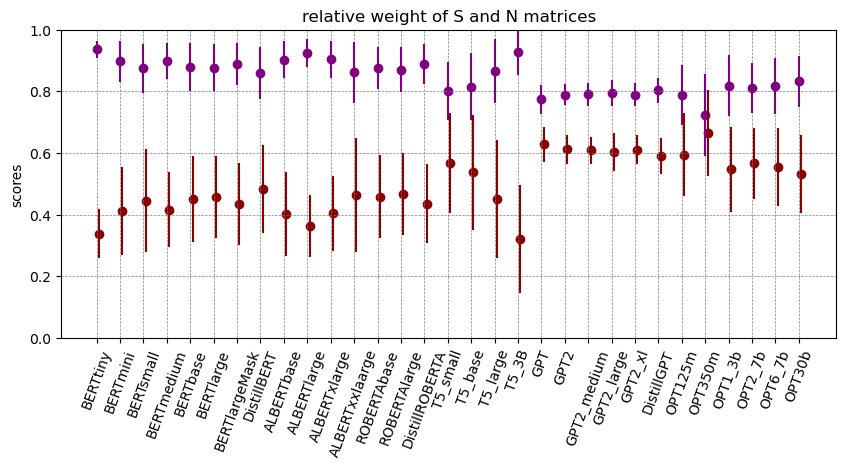

In [20]:
SList = [SBert_tiny, SBert_mini, SBert_small, SBert_medium, SBert_base, SBert_large, SBert_largeMasking, SDistillBERT] + \
         [SALBERT_base, SALBERT_large, SALBERT_xlarge, SALBERT_xxlarge] + \
         [SROBERTA_base, SROBERTA_large, SDistillROBERTA] + \
         [ST5_small, ST5_base, ST5_large, ST5_3B] + \
         [SGPT, SGPT2, SGPT2_medium, SGPT2_large, SGPT2_xl, SDistillGPT2] + \
         [SOPT125m, SOPT350m, SOPT1_3b, SOPT2_7b, SOPT6_7b, SOPT13b] #, SOPT66b]

NList = [NBert_tiny, NBert_mini, NBert_small, NBert_medium, NBert_base, NBert_large, NBert_largeMasking, NDistillBERT] + \
         [NALBERT_base, NALBERT_large, NALBERT_xlarge, NALBERT_xxlarge] + \
         [NROBERTA_base, NROBERTA_large, NDistillROBERTA] + \
         [NT5_small, NT5_base, NT5_large, NT5_3B] + \
         [NGPT, NGPT2, NGPT2_medium, NGPT2_large, NGPT2_xl, NDistillGPT2] + \
         [NOPT125m, NOPT350m, NOPT1_3b, NOPT2_7b, NOPT6_7b, NOPT13b] #, NOPT66b]

names = ['BERTtiny', 'BERTmini', 'BERTsmall', 'BERTmedium',  'BERTbase', 'BERTlarge', 'BERTlargeMask', 'DistillBERT'] + \
         ['ALBERTbase', 'ALBERTlarge', 'ALBERTxlarge', 'ALBERTxxlaarge'] + \
         ['ROBERTAbase', 'ROBERTAlarge', 'DistillROBERTA'] + \
         ['T5_small', 'T5_base', 'T5_large', 'T5_3B'] + \
         ['GPT', 'GPT2', 'GPT2_medium', 'GPT2_large', 'GPT2_xl', 'DistillGPT'] + \
         ['OPT125m', 'OPT350m', 'OPT1_3b', 'OPT2_7b', 'OPT6_7b', 'OPT30b'] #, 'OPT66b']

plt.figure(figsize=(10,4))

for i, model in enumerate(SList):

    plt.scatter(i*np.ones(SList[i].size),SList[i].flatten(),color='purple',alpha=.001)
    plt.scatter(i,SList[i].flatten().mean(),color='purple')
    plt.errorbar(i,SList[i].flatten().mean(),
                SList[i].flatten().std(),
                color='purple')
    plt.scatter((i+.1)*np.ones(NList[i].size),NList[i].flatten(),color='darkred',alpha=.001)
    plt.scatter(i+.1,NList[i].flatten().mean(),color='darkred')
    plt.errorbar(i+.1,NList[i].flatten().mean(),
                NList[i].flatten().std(),
                color='darkred')
    
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.title('relative weight of S and N matrices')
plt.ylabel('scores')
plt.xticks(np.arange(len(names)),names)
plt.xticks(rotation=70)
plt.ylim(0,1)

(0.0, 1.0)

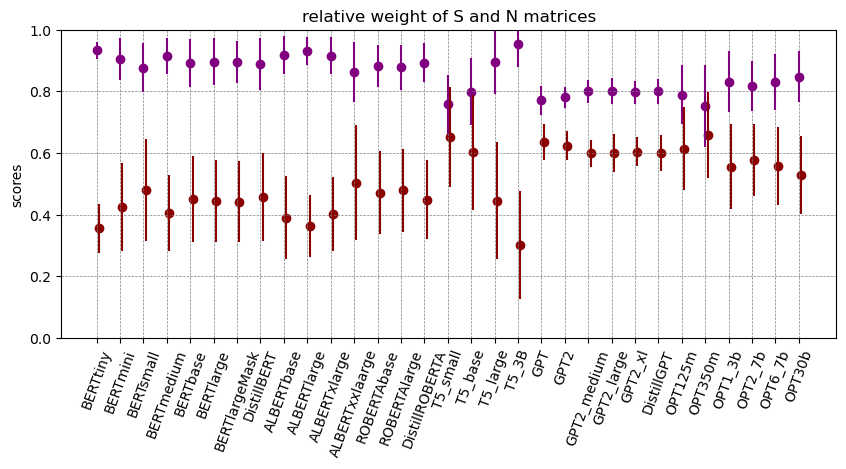

In [22]:
SList = [SBert_tiny, SBert_mini, SBert_small, SBert_medium, SBert_base, SBert_large, SBert_largeMasking, SDistillBERT] + \
         [SALBERT_base, SALBERT_large, SALBERT_xlarge, SALBERT_xxlarge] + \
         [SROBERTA_base, SROBERTA_large, SDistillROBERTA] + \
         [ST5_small, ST5_base, ST5_large, ST5_3B] + \
         [SGPT, SGPT2, SGPT2_medium, SGPT2_large, SGPT2_xl, SDistillGPT2] + \
         [SOPT125m, SOPT350m, SOPT1_3b, SOPT2_7b, SOPT6_7b, SOPT13b] #, SOPT66b]

NList = [NBert_tiny, NBert_mini, NBert_small, NBert_medium, NBert_base, NBert_large, NBert_largeMasking, NDistillBERT] + \
         [NALBERT_base, NALBERT_large, NALBERT_xlarge, NALBERT_xxlarge] + \
         [NROBERTA_base, NROBERTA_large, NDistillROBERTA] + \
         [NT5_small, NT5_base, NT5_large, NT5_3B] + \
         [NGPT, NGPT2, NGPT2_medium, NGPT2_large, NGPT2_xl, NDistillGPT2] + \
         [NOPT125m, NOPT350m, NOPT1_3b, NOPT2_7b, NOPT6_7b, NOPT13b] #, NOPT66b]

names = ['BERTtiny', 'BERTmini', 'BERTsmall', 'BERTmedium',  'BERTbase', 'BERTlarge', 'BERTlargeMask', 'DistillBERT'] + \
         ['ALBERTbase', 'ALBERTlarge', 'ALBERTxlarge', 'ALBERTxxlaarge'] + \
         ['ROBERTAbase', 'ROBERTAlarge', 'DistillROBERTA'] + \
         ['T5_small', 'T5_base', 'T5_large', 'T5_3B'] + \
         ['GPT', 'GPT2', 'GPT2_medium', 'GPT2_large', 'GPT2_xl', 'DistillGPT'] + \
         ['OPT125m', 'OPT350m', 'OPT1_3b', 'OPT2_7b', 'OPT6_7b', 'OPT30b'] #, 'OPT66b']

plt.figure(figsize=(10,4))

for i, model in enumerate(SList):

    plt.scatter(i*np.ones(SList[i].size),SList[i].flatten(),color='purple',alpha=.001)
    plt.scatter(i,np.median(SList[i].flatten()),color='purple')
    plt.errorbar(i,np.median(SList[i].flatten()),
                SList[i].flatten().std(),
                color='purple')
    plt.scatter((i+.1)*np.ones(NList[i].size),NList[i].flatten(),color='darkred',alpha=.001)
    plt.scatter(i+.1,np.median(NList[i].flatten()),color='darkred')
    plt.errorbar(i+.1,np.median(NList[i].flatten()),
                NList[i].flatten().std(),
                color='darkred')
    
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.title('relative weight of S and N matrices')
plt.ylabel('scores')
plt.xticks(np.arange(len(names)),names)
plt.xticks(rotation=70)
plt.ylim(0,1)